<a href="https://colab.research.google.com/github/irene880104/datasharing/blob/master/HW3_Supply%20Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biopharma

## Install and import packages

In [ ]:
%reset -f
# Install and import packages
!pip install gurobipy
!pip install tabulate

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import datetime as dt
_empty_series = pd.Series(dtype=float)

## Exchange rate

In [ ]:
!pip install forex_python

from forex_python.converter import CurrencyRates
from datetime import datetime, timedelta

import numpy as np
from scipy.stats import multivariate_normal


In [ ]:
def get_monthly_exchange_rates(start_year, end_year, base_currency, target_currencies):
    c = CurrencyRates()
    rates = {currency: [] for currency in target_currencies}

    # Generate a list of first day of each month in the specified range
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    current_date = start_date

    while current_date <= end_date:
        for currency in target_currencies:
            try:
                # Get exchange rate for the first day of the month
                rate = c.get_rate(base_currency, currency, current_date)
                rates[currency].append((current_date.strftime("%Y-%m"), rate))
            except Exception as e:
                print(f"Error fetching rate for {currency} on {current_date.strftime('%Y-%m')}: {e}")
                rates[currency].append((current_date.strftime("%Y-%m"), None))

        # Move to the first day of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return rates

In [ ]:
# Specify the currencies
base_currency = "USD"
target_currencies = ["BRL", "EUR", "INR", "JPY", "MXN"]

# Fetch exchange rates from Jan 2019 to Dec 2023
exchange_rates = get_monthly_exchange_rates(2019, 2023, base_currency, target_currencies)

# Print the rates
for currency, rates in exchange_rates.items():
    print(f"Exchange rates for {currency} against {base_currency}:")
    for date, rate in rates:
        print(f"{date}: {rate}")
    print("\n")

Exchange rates for BRL against USD:
2019-01: 3.8812227074235808
2019-02: 3.6709964257693315
2019-03: 3.7808134938065536
2019-04: 3.8771804912780348
2019-05: 3.9267249064004286
2019-06: 3.9872657160792757
2019-07: 3.8272094457661465
2019-08: 3.8255866630424937
2019-09: 4.157212758245742
2019-10: 4.164433841071756
2019-11: 3.989316814794865
2019-12: 4.230468038608632
2020-01: 4.0196724230016025
2020-02: 4.266829533116178
2020-03: 4.485014120433634
2020-04: 5.2440563277249455
2020-05: 5.384792203015815
2020-06: 5.3324937027707815
2020-07: 5.442857142857142
2020-08: 5.167032410533423
2020-09: 5.433052473512972
2020-10: 5.6008339006126615
2020-11: 5.779363993845102
2020-12: 5.311915106951871
2021-01: 5.193953223046206
2021-02: 5.442320423700762
2021-03: 5.579025968638513
2021-04: 5.631619274646687
2021-05: 5.346548584671412
2021-06: 5.202126789366054
2021-07: 4.960871760350051
2021-08: 5.1060465898578755
2021-09: 5.152407548447152
2021-10: 5.415172413793104
2021-11: 5.650889618241493
2021-1

In [ ]:
# Convert the data into a NumPy array for analysis
# Note: This example assumes all currencies have the same number of rates and ignores missing values

# Extract rates for each currency, ensuring they're in the same order for each month
rates_list = [rates for rates in exchange_rates.values() if all(rate is not None for _, rate in rates)]
currency_data = np.array([[rate for _, rate in currency_rates] for currency_rates in rates_list])

# Transpose to get rows as observations (dates) and columns as variables (currencies)
currency_data = currency_data.T

# Ensure no NaN values; this method requires complete data
if np.isnan(currency_data).any():
    print("Data contains NaN values. Please handle missing data before proceeding.")
else:
    # Estimate the mean and covariance
    mean_vector = np.mean(currency_data, axis=0)
    covariance_matrix = np.cov(currency_data, rowvar=False)

    # Fit the multivariate normal distribution
    mvn_distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

    print("Mean Vector:\n", mean_vector)
    print("Covariance Matrix:\n", covariance_matrix)
    # The distribution is now defined and can be used for further analysis


Mean Vector:
 [  4.91679403   0.89791993  75.7301565  119.26608249  19.81262121]
Covariance Matrix:
 [[ 3.42594387e-01 -2.13708474e-03  1.22952065e+00  1.27836101e+00
   3.46111090e-01]
 [-2.13708474e-03  2.17002114e-03  1.24913080e-01  5.21137097e-01
  -1.73246912e-02]
 [ 1.22952065e+00  1.24913080e-01  2.02929685e+01  6.06245515e+01
  -2.53203458e+00]
 [ 1.27836101e+00  5.21137097e-01  6.06245515e+01  2.26189966e+02
  -1.36106797e+01]
 [ 3.46111090e-01 -1.73246912e-02 -2.53203458e+00 -1.36106797e+01
   2.22048686e+00]]


In [ ]:
sample = mvn_distribution.rvs(size=100, random_state = 42)
print("Sampled draw:", sample)

Sampled draw: [[  5.33903349   0.86624389  73.11981139 111.97694712  20.64765002]
 [  5.61063294   0.92965032  79.34556062 122.17329041  21.55596358]
 [  4.15813507   0.91417896  76.7855405  126.46411362  19.35969562]
 [  4.23125735   0.91322667  76.09887012 128.22232772  18.85391928]
 [  4.22179671   0.86010131  69.36898962  97.33465587  21.08086944]
 [  4.20257082   0.91005302  73.04890421 118.17847894  19.38359263]
 [  5.52254216   0.94084113  81.67286881 127.44813012  20.76991959]
 [  4.54491386   0.92635342  81.90518666 137.20937227  17.19405622]
 [  4.81916288   0.84413823  73.08268079 108.06642289  20.51725975]
 [  4.96882583   0.9037901   77.42010383 130.46304769  19.74663873]
 [  4.8357399    0.88815955  73.90781372 114.47381542  19.15586176]
 [  4.50421436   0.87948083  70.46558563 105.60838233  19.68870145]
 [  4.40187321   0.92911917  77.82142211 126.37336413  18.3082516 ]
 [  4.95103639   0.85179546  69.65778441  99.06923146  21.84976691]
 [  6.09965524   0.80073596  77.01

In [ ]:
sample = mvn_distribution.rvs(size=100, random_state = 42)

column_names = ['Brazil', 'Germany', 'India', 'Japan', 'Mexico']
currency_100 = pd.DataFrame(sample, columns=column_names)
currency_100['US'] = 1

currency_100.shape[0]

100

In [ ]:
currency_100

,Brazil,Germany,India,Japan,Mexico,US
0,5.339033,0.866244,73.119811,111.976947,20.647650,1
1,5.610633,0.929650,79.345561,122.173290,21.555964,1
2,4.158135,0.914179,76.785541,126.464114,19.359696,1
3,4.231257,0.913227,76.098870,128.222328,18.853919,1
4,4.221797,0.860101,69.368990,97.334656,21.080869,1
...,...,...,...,...,...,...
95,6.213829,0.886242,77.527642,122.822677,20.152830,1
96,4.396904,0.859546,75.069506,121.384236,17.492399,1
97,5.186395,0.923140,80.662290,140.793295,16.972230,1
98,5.357669,0.935326,78.511699,118.709868,21.078569,1


### Raw Data

In [ ]:

demand = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'd_h': [  7, 15,  5,  7,  3, 18],
    'd_r': [  7, 12,  3,  8,  3, 17],
})
demand.set_index('from', inplace=True)

caps = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'cap': [18, 45, 18, 10, 30, 22],
})
caps.set_index('plant', inplace=True)

pcosts = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'fc_p': [20, 45, 14, 13, 30, 23],
    'fc_h': [ 5, 13,  3,  4,  6,  5],
    'fc_r': [ 5, 13,  3,  4,  6,  5],
    'rm_h': [3.6, 3.9, 3.6, 3.9, 3.6, 3.6],
    'pc_h': [5.1, 6.0, 4.5, 6.0, 5.0, 5.0],
    'rm_r': [4.6, 5.0, 4.5, 5.1, 4.6, 4.5],
    'pc_r': [6.6, 7.0, 6.0, 7.0, 6.5, 6.5],
})
pcosts.set_index('plant', inplace=True)

tcosts = pd.DataFrame({
    'from': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'LatinAmerica': [ 0.20, 0.45, 0.50, 0.50, 0.40, 0.45],
    'Europe':       [ 0.45, 0.20, 0.35, 0.40, 0.30, 0.30],
    'AsiaWoJapan':  [ 0.50, 0.35, 0.20, 0.30, 0.50, 0.45],
    'Japan':        [ 0.50, 0.40, 0.30, 0.10, 0.45, 0.45],
    'Mexico':       [ 0.40, 0.30, 0.50, 0.45, 0.20, 0.25],
    'U.S.':           [ 0.45, 0.30, 0.45, 0.45, 0.25, 0.20],
})
tcosts.set_index('from', inplace=True)

duties = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'duty': [ 0.30, 0.03, 0.27, 0.06, 0.35, 0.04],
})
duties.set_index('from', inplace=True)

# Your provided exchange_rate_data


exrate0 = currency_100.copy()

# Minimize cost using Gurobi Binary and Integer optimizer

## Functions to calculate cost, unmet demand, and excess capacity

In [ ]:
# identify number of supply and demand location for iterations
n_ctry = range(demand.shape[0])
n_lines = range(demand.shape[1]+1)

# Objective function to calculate cost
#def calc_total_cost(dec_plant, dec_h, dec_r, base_yr=2019, selected_yr=2023, tariff=0):
def calc_total_cost(dec_plant, dec_h, dec_r, currency_row, tariff=0):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    # Adjust the cost using exchange rate
    reindx = [4.33, 0.92, 71.48, 109.82, 18.65, 1]/ exrate.iloc[currency_row,:]

    pcosts_rev = pcosts.values * reindx.values.reshape(-1,1)
    pcosts_rev = pd.DataFrame(pcosts_rev, columns=pcosts.columns[0:], index=pcosts.index)
    # return pcosts_rev
    # pcosts_rev = adj_pcosts_exrate(2019, 2023)
    # print(pcosts_rev)

    duties_mat = np.zeros(len(duties)) + (1 + duties['duty'].values)[:, np.newaxis]
    np.fill_diagonal(duties_mat, 1)
    duties_mat = pd.DataFrame(duties_mat.T, index=pcosts_rev.index, columns=duties.index)
    duties_mat.loc['Germany', 'U.S.'] += tariff
    duties_mat.loc['U.S.', 'Europe']  += tariff

    vcosts_h = tcosts.add(pcosts_rev['rm_h'], axis=0).add(pcosts_rev['pc_h'], axis=0) * duties_mat
    vcosts_r = tcosts.add(pcosts_rev['rm_r'], axis=0).add(pcosts_rev['pc_r'], axis=0) * duties_mat
    # print(vcosts_h)
    # print(vcosts_r)

    fc = pcosts_rev[['fc_p','fc_h','fc_r']].values
    vh = (vcosts_h * x_h).values
    vr = (vcosts_r * x_r).values
    total_cost = sum(0.2 * fc[i,j] for i in n_ctry for j in n_lines) + sum(0.8 * fc[i,j] * x_plant[i,j] for i in n_ctry for j in n_lines) + sum(vh[i,j] for i in n_ctry for j in n_ctry) + sum(vr[i,j] for i in n_ctry for j in n_ctry)
    return total_cost


# Calculate excess capacity given decision variables
def calc_excess_cap(dec_plant, dec_h, dec_r):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    excess_cap = (x_plant * caps.values).copy()
    excess_cap[:, 0] -= (np.sum(x_h, axis=1) + np.sum(x_r, axis=1))
    excess_cap[:, 1] -= np.sum(x_h, axis=1)
    excess_cap[:, 2] -= np.sum(x_r, axis=1)
    return excess_cap

# Calculate unmet demand given decision variables
def calc_unmet_demand(dec_h, dec_r):
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    x_h_sum = np.sum(x_h, axis=0)
    x_r_sum = np.sum(x_r, axis=0)
    unmet_demand = (demand.values).copy()
    unmet_demand = np.column_stack((x_h_sum - unmet_demand[:, 0], x_r_sum - unmet_demand[:, 1]))

    return unmet_demand


## Gurobi optimizer

In [ ]:
# Create a Gurobi model
model = Model("MinimizeCost")

# Assign initial value of decision variables
dec_plant = {(i, j): 1 for i in n_ctry for j in n_lines}
dec_h     = {(i, j): 1 for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): 1 for i in n_ctry for j in n_ctry}

# Define decision variables
dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}")    for i in n_ctry for j in n_lines}
dec_h     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

# Excess Capacity constraints
excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
for i in n_ctry:
    for j in n_lines:
        model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")


# Unmet demand constraints
unnmet_demand = calc_unmet_demand(dec_h, dec_r)
for i in n_ctry:
    for j in range(2):
        model.addConstr(unnmet_demand[i,j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")


# Question 1

1. Sample 100 draws from the exchange rate distribution and for each draw determine the optimal network configuration (which plants/lines should be open).


In [ ]:
exrate = currency_100.copy()
tariff = 0
n= -1
final_cost = []
optimal_df = []
optimal_op_r = []
optimal_op_h = []
optimal_op_plant = []
while n< exrate.shape[0]-1:

    n+=1

    # Update the model
    model.update()

    # Set objective function - Total cost = Fixed cost + Variable costs of Highcal and Relax lines
    model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, currency_row =n , tariff=0), GRB.MINIMIZE)


    # Suppress optimization output
    model.Params.OutputFlag = 0

    # Optimize the model
    model.optimize()

    # Extract results to print as table
    op_plant = pd.DataFrame([[dec_plant[i, j].x for j in n_lines] for i in n_ctry], columns = ['Plant','H','R'], index=caps.index)
    op_h     = pd.DataFrame([[dec_h[i, j].x for j in n_ctry] for i in n_ctry], columns = tcosts.columns, index=tcosts.index)
    op_r     = pd.DataFrame([[dec_r[i, j].x for j in n_ctry] for i in n_ctry], columns = tcosts.columns, index=tcosts.index)

    optimal_df.append(op_plant)
    final_cost.append(round(model.objVal,2))
    optimal_op_h.append(op_h)
    optimal_op_r.append(op_r)
    optimal_op_plant.append(op_plant)

    print(f"Minimun Cost: $ {round(model.objVal,2)} in round {n+1}")
    print("\nHighCal Flow\n")
    print(tabulate(op_h, headers='keys', tablefmt='pretty'))
    print("\nRelax Flow\n")
    print(tabulate(op_r, headers='keys', tablefmt='pretty'))
    print("\nStrategy\n")
    print(tabulate(op_plant, headers='keys', tablefmt='pretty'))


Minimun Cost: $ 1205.04 in round 1

HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  3.0   |     5.0     |  7.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  8.0   |     0.0     |  0.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  4.0   |     0.0     |  0.0  |  0.0   | 18.0 |
+---------+--------------+--------+-------------+-------+--------+------+

Relax Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+

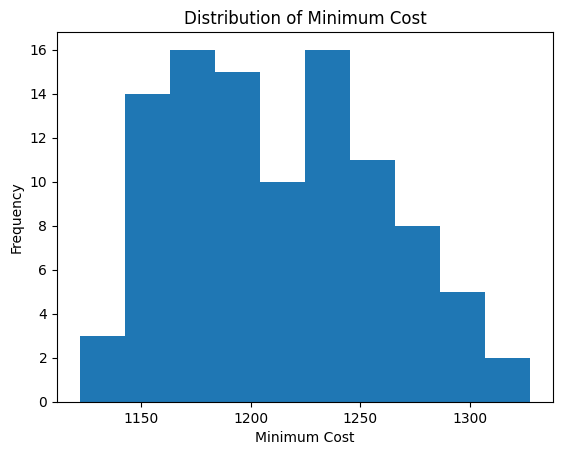

In [ ]:
# Distribution of all the min costs
import matplotlib.pyplot as plt

# Create a DataFrame
cost = pd.DataFrame(final_cost, columns=['Minimum Cost'])

# Plot the DataFrame
plt.hist(cost['Minimum Cost'])
plt.title('Distribution of Minimum Cost')
plt.xlabel('Minimum Cost')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
# Top 3 min minimum costs
min_cost_index = cost['Minimum Cost'].nsmallest(3)

r = min_cost_index.index[0]
print(optimal_df[r],'\n\ncost:', final_cost[r],'\n')

r = min_cost_index.index[1]

print(optimal_df[r],'\n\ncost:', final_cost[r],'\n')

r = min_cost_index.index[2]

print(optimal_df[r],'\n\ncost:', final_cost[r],'\n')

         Plant    H    R
plant                   
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0 

cost: 1121.93 

         Plant    H    R
plant                   
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0 

cost: 1135.81 

         Plant    H    R
plant                   
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0 

cost: 1140.3 



In [ ]:
#Concatenate all DataFrames in the list
merged_df = pd.concat(optimal_df)

# Sum values across all DataFrames for each index
summed_df = merged_df.groupby(merged_df.index).sum()

# Display the result
print("Summed DataFrame: open frequency")
print(summed_df['Plant'])

Summed DataFrame: open frequency
plant
Brazil      99.0
Germany    100.0
India      100.0
Japan       72.0
Mexico      95.0
U.S.        94.0
Name: Plant, dtype: float64


# Question 2

In [ ]:
plant_lists = [df['Plant'].tolist() for df in optimal_df]
country = ['Brazil', 'Germany','India','Japan','Mexico', 'U.S.']
# Print the result
print(plant_lists)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1

In [ ]:
from collections import Counter

# Your list of lists
plant_combinations = plant_lists.copy()

# Count the frequency of each combination
combination_counts = Counter(tuple(combination) for combination in plant_combinations)
print(country)
# Print the result
for combination, count in combination_counts.items():
    print(f"Combination: {combination}, Frequency: {count}")


['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.']
Combination: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0), Frequency: 61
Combination: (1.0, 1.0, 1.0, 0.0, 1.0, 1.0), Frequency: 27
Combination: (1.0, 1.0, 1.0, 1.0, 0.0, 1.0), Frequency: 5
Combination: (1.0, 1.0, 1.0, 1.0, 1.0, 0.0), Frequency: 6
Combination: (0.0, 1.0, 1.0, 0.0, 1.0, 1.0), Frequency: 1


In [ ]:

most_country = []
second_most = []
plant = []
for con in country:
    df = merged_df['Plant'].reset_index().copy()

    # Add a new column to mark the groups
    df['Group'] = (df.index // 6) + 1


    # Create a new DataFrame for the desired countries and U.S.
    result_df = df[df['plant'].isin(country)]

    # Pivot the DataFrame to get the desired format
    result_df = result_df.pivot(index='Group', columns='plant', values='Plant')

    # Drop the unnecessary columns and reset the index
    result_df = result_df.drop(columns=con).reset_index()

# Display the resulting DataFrame

    plant_sums = result_df.sum(axis=0)

    plant.append(plant_sums)

# Get the index (plant name) of the second largest value
    second_largest_plant_index = plant_sums.nlargest(2).index[1]
    most_country.append(second_largest_plant_index)

    third_largest_plant_index = plant_sums.nlargest(3).index[2]
    second_most.append(third_largest_plant_index)
    #print(f"The index of the second largest plant is: {con} & {second_largest_plant_index} & {third_largest_plant_index}")


In [ ]:
# Concatenate the DataFrames in the list
plant_1 = pd.concat(plant)

# Reset the index of the resulting DataFrame
plant_1 = plant_1.reset_index(drop=False)

# Add a new column to mark the groups
plant_1['Group'] = (plant_1.index // 6) + 1

plant_1 = plant_1[plant_1['plant'] != 'Group']
plant_1  = plant_1 .rename(columns={0: 'freq'})


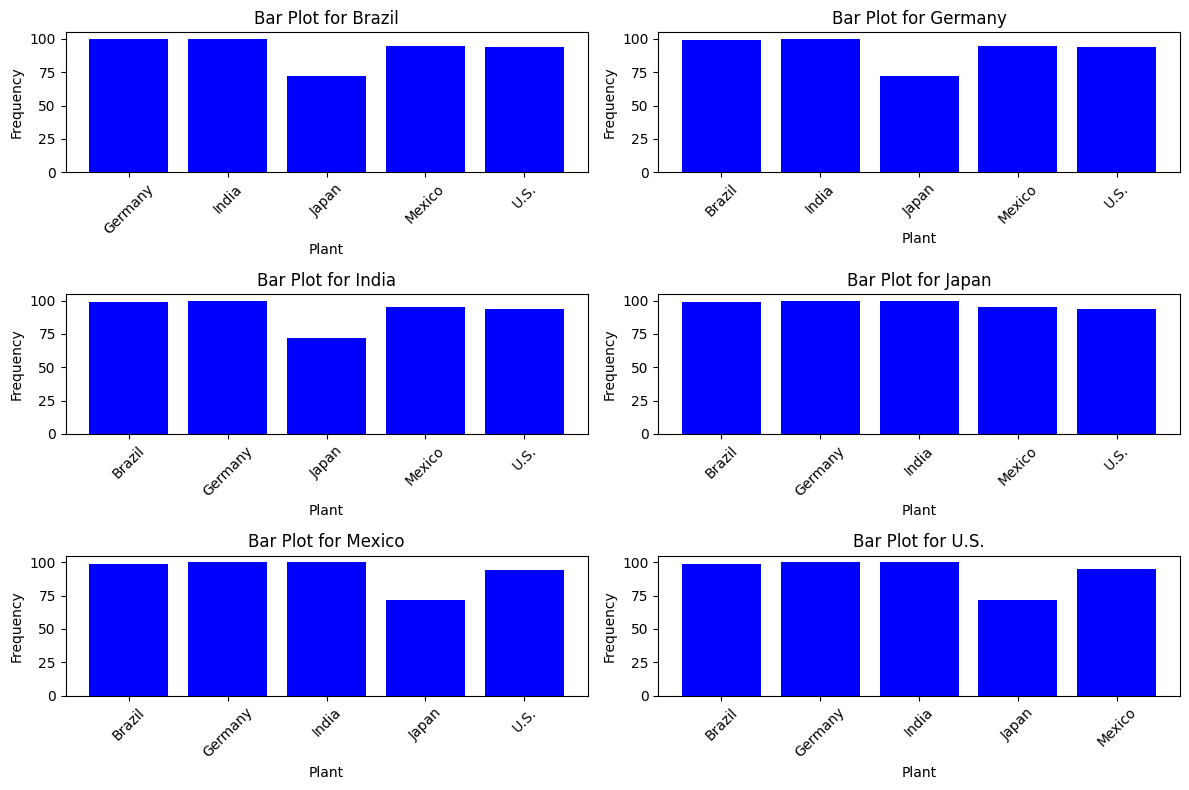

In [ ]:
df = plant_1.copy()
con = -1

# Set up a 3x2 subplot layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

# Iterate over unique groups
for group, ax in zip(df['Group'].unique(), axes.flatten()):
    con += 1
    group_df = df[df['Group'] == group]

    # Change line plot to bar plot
    ax.bar(x=group_df['plant'], height=group_df['freq'], color='blue')

    ax.set_xlabel('Plant')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Bar Plot for {country[con]}')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


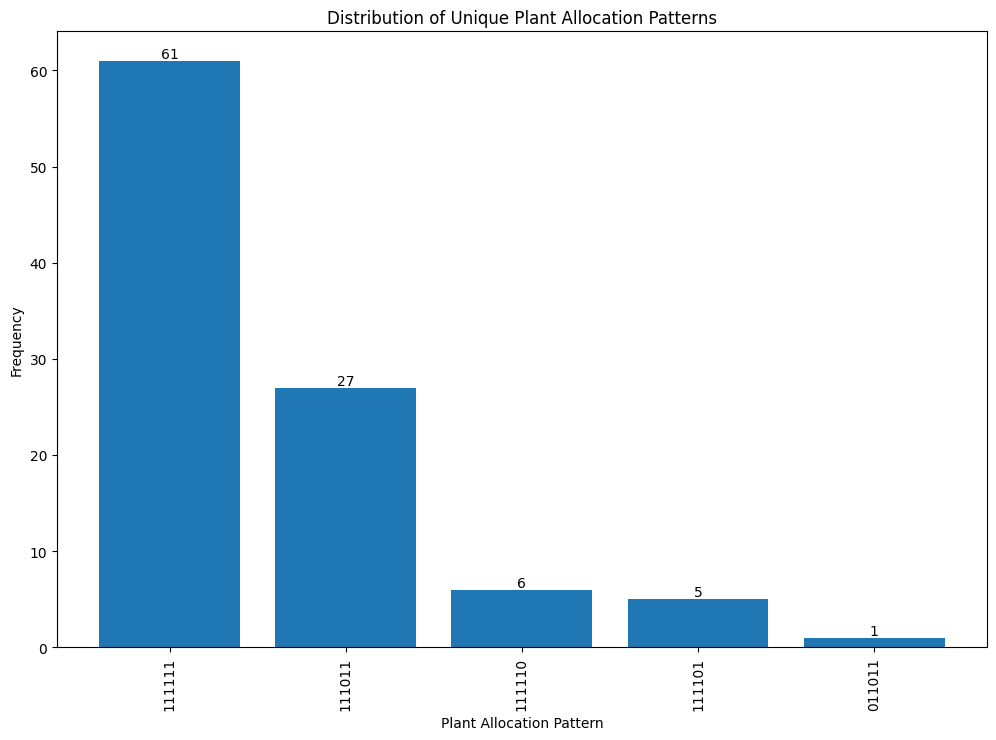

In [ ]:
# Step 1: Initialize a list to store the concatenated binary values for each scenario's plant allocation
allocation_patterns = []

# Loop through each DataFrame in the optimal_df list
for df in optimal_df:
    # Extract the first column (plant allocation) and convert it to a string pattern
    pattern = ''.join(df.iloc[:, 0].astype(int).astype(str))
    allocation_patterns.append(pattern)

allocation_series = pd.Series(allocation_patterns)
pattern_counts = allocation_series.value_counts()

# Step 3: Visualize the distribution of unique allocation patterns
plt.figure(figsize=(12, 8))  # Adjust size as necessary
bars = plt.bar(pattern_counts.index, pattern_counts.values)  # Capture the bars as a variable

plt.title('Distribution of Unique Plant Allocation Patterns')
plt.xlabel('Plant Allocation Pattern')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate for better readability if necessary

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, int(yval), va='bottom', ha='center')

plt.show()

In [ ]:
correlation_matrix_exchange = exrate.corr()
print(correlation_matrix_exchange)

           Brazil   Germany     India     Japan    Mexico  US
Brazil   1.000000  0.085261  0.588411  0.294579  0.396017 NaN
Germany  0.085261  1.000000  0.581673  0.698332 -0.108084 NaN
India    0.588411  0.581673  1.000000  0.899406 -0.266007 NaN
Japan    0.294579  0.698332  0.899406  1.000000 -0.514997 NaN
Mexico   0.396017 -0.108084 -0.266007 -0.514997  1.000000 NaN
US            NaN       NaN       NaN       NaN       NaN NaN


In [ ]:
allocations_list = allocation_series.apply(lambda x: [int(char) for char in x]).tolist()
allocation_df = pd.DataFrame(allocations_list, columns=country)
allocation_df
correlation_matrix_plants = allocation_df.corr()
print(correlation_matrix_plants)

           Brazil  Germany  India     Japan    Mexico      U.S.
Brazil   1.000000      NaN    NaN  0.161165 -0.023057 -0.025392
Germany       NaN      NaN    NaN       NaN       NaN       NaN
India         NaN      NaN    NaN       NaN       NaN       NaN
Japan    0.161165      NaN    NaN  1.000000 -0.143066 -0.157552
Mexico  -0.023057      NaN    NaN -0.143066  1.000000 -0.057961
U.S.    -0.025392      NaN    NaN -0.157552 -0.057961  1.000000


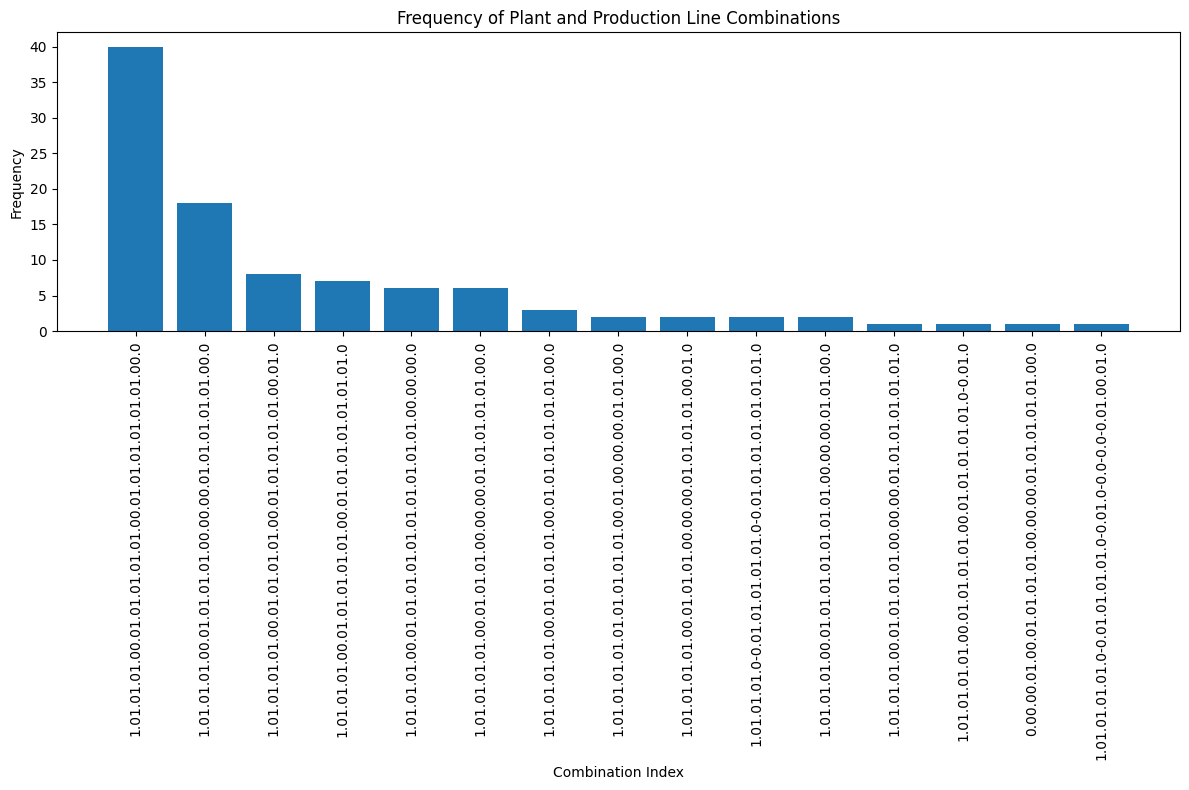

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming optimal_df is a list of DataFrames
# Convert each DataFrame into a unique string representation
combination_strings = [''.join(df.astype(str).values.flatten()) for df in optimal_df]

# Count the frequency of each unique combination
combination_counts = Counter(combination_strings)

# Sort combinations by frequency in descending order
sorted_combinations = sorted(combination_counts.items(), key=lambda x: x[1], reverse=True)
sorted_combination_keys = [item[0] for item in sorted_combinations]
sorted_combination_values = [item[1] for item in sorted_combinations]

# Plotting
plt.figure(figsize=(12, 8))  # Adjust size as needed for clarity
plt.bar(range(len(sorted_combination_keys)), sorted_combination_values)
plt.title('Frequency of Plant and Production Line Combinations')
plt.xlabel('Combination Index')  # Changed to index since actual combinations might be lengthy
plt.ylabel('Frequency')
plt.xticks(range(len(sorted_combination_keys)), labels=sorted_combination_keys, rotation=90)


plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [ ]:
sorted_combination_keys

['1.01.01.01.00.01.01.01.01.01.00.01.01.01.01.01.01.00.0',
 '1.01.01.01.00.01.01.01.01.00.00.00.01.01.01.01.01.00.0',
 '1.01.01.01.01.00.01.01.01.01.00.01.01.01.01.01.00.01.0',
 '1.01.01.01.00.01.01.01.01.01.00.01.01.01.01.01.01.01.0',
 '1.01.01.01.00.01.01.01.01.01.01.01.01.01.01.00.00.00.0',
 '1.01.01.01.01.00.01.01.01.00.00.00.01.01.01.01.01.00.0',
 '1.01.01.01.01.00.01.01.01.01.00.01.01.01.01.01.01.00.0',
 '1.01.01.01.01.01.01.01.01.01.00.01.00.00.00.01.01.00.0',
 '1.01.01.01.01.00.01.01.01.00.00.00.01.01.01.01.00.01.0',
 '1.01.01.01.0-0.01.01.01.01.01.0-0.01.01.01.01.01.01.01.0',
 '1.01.01.01.00.01.01.01.01.01.01.01.00.00.00.01.01.00.0',
 '1.01.01.01.00.01.01.01.01.00.00.00.01.01.01.01.01.01.0',
 '1.01.01.01.01.00.01.01.01.01.00.01.01.01.01.01.0-0.01.0',
 '0.00.00.01.00.01.01.01.01.00.00.00.01.01.01.01.01.00.0',
 '1.01.01.01.01.0-0.01.01.01.01.0-0.01.0-0.0-0.0-0.01.00.01.0']

In [ ]:
data_1 = ['01.01.01.01.00.01.01.01.01.01.00.01.01.01.01.01.01.00']

# Split digits based on dot (.)
split_data_1 = [list(map(float, line.split('.'))) for line in data_1]

# Reshape the data into a 3x6 DataFrame
top_1 = pd.DataFrame(np.array(split_data_1).reshape(6, 3), columns=['Plant', 'H', 'R'],index=country)

print(top_1)


data_2 = ['01.01.01.01.00.01.01.01.01.00.00.00.01.01.01.01.01.00']

# Split digits based on dot (.)
split_data_2 = [list(map(float, line.split('.'))) for line in data_2]

# Reshape the data into a 3x6 DataFrame
top_2 = pd.DataFrame(np.array(split_data_2).reshape(6, 3), columns=['Plant', 'H', 'R'],index=country)

print(top_2)

data_3 = ['01.01.01.01.01.00.01.01.01.01.00.01.01.01.01.01.00.01']

# Split digits based on dot (.)
split_data_3 = [list(map(float, line.split('.'))) for line in data_3]

# Reshape the data into a 3x6 DataFrame
top_3 = pd.DataFrame(np.array(split_data_3).reshape(6, 3), columns=['Plant', 'H', 'R'],index=country)

print(top_3)


         Plant    H    R
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0
         Plant    H    R
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      0.0  0.0  0.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0
         Plant    H    R
Brazil     1.0  1.0  1.0
Germany    1.0  1.0  0.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  0.0  1.0


In [ ]:
desired_strategy_1 = {
    "Brazil": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Germany": {"Plant": 1.0, "H": 0.0, "R": 1.0},
    "India": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Japan": {"Plant": 1.0, "H": 0.0, "R": 1.0},
    "Mexico": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "U.S.": {"Plant": 1.0, "H": 1.0, "R": 0.0},
}

In [ ]:
desired_strategy_2 = {
    "Brazil": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Germany": {"Plant": 1.0, "H": 0.0, "R": 1.0},
    "India": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Japan": {"Plant": 0.0, "H": 0.0, "R": 0.0},
    "Mexico": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "U.S.": {"Plant": 1.0, "H": 1.0, "R": 0.0},
}

In [ ]:
desired_strategy_3 = {
    "Brazil": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Germany": {"Plant": 1.0, "H": 1.0, "R": 0.0},
    "India": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "Japan": {"Plant": 1.0, "H": 0.0, "R": 1.0},
    "Mexico": {"Plant": 1.0, "H": 1.0, "R": 1.0},
    "U.S.": {"Plant": 1.0, "H": 0.0, "R": 1.0},
}

In [ ]:
def find_matching_indexes(optimal_df_list, desired_strategy):
    matching_indexes = []

    for index, df in enumerate(optimal_df_list):
        extracted_strategy = {plant: {"Plant": row["Plant"], "H": row["H"], "R": row["R"]}
                              for plant, row in df.iterrows()}
        if strategy_matches_desired(extracted_strategy, desired_strategy):
            matching_indexes.append(index)

    return matching_indexes

def strategy_matches_desired(extracted_strategy, desired_strategy):
    for plant, strategy_details in desired_strategy.items():
        if plant not in extracted_strategy or extracted_strategy[plant] != strategy_details:
            return False
    return True


In [ ]:
matching_indexes_1 = find_matching_indexes(optimal_df, desired_strategy_1)
print("Matching indexes:", matching_indexes_1)
for i in matching_indexes_1:
    print(f"Cost: {final_cost[i]}, Index: {i}")

Matching indexes: [0, 1, 2, 5, 6, 9, 10, 16, 17, 18, 19, 28, 30, 31, 38, 39, 48, 50, 51, 53, 55, 59, 60, 61, 62, 63, 64, 65, 68, 73, 75, 77, 80, 83, 87, 89, 90, 93, 95, 99]
Cost: 1205.04, Index: 0
Cost: 1147.52, Index: 1
Cost: 1242.72, Index: 2
Cost: 1257.98, Index: 5
Cost: 1150.09, Index: 6
Cost: 1197.07, Index: 9
Cost: 1239.49, Index: 10
Cost: 1175.48, Index: 16
Cost: 1170.56, Index: 17
Cost: 1202.18, Index: 18
Cost: 1175.69, Index: 19
Cost: 1207.03, Index: 28
Cost: 1218.49, Index: 30
Cost: 1140.3, Index: 31
Cost: 1182.43, Index: 38
Cost: 1253.99, Index: 39
Cost: 1189.99, Index: 48
Cost: 1121.93, Index: 50
Cost: 1173.37, Index: 51
Cost: 1173.4, Index: 53
Cost: 1230.25, Index: 55
Cost: 1159.04, Index: 59
Cost: 1197.32, Index: 60
Cost: 1184.74, Index: 61
Cost: 1150.09, Index: 62
Cost: 1196.19, Index: 63
Cost: 1203.57, Index: 64
Cost: 1135.81, Index: 65
Cost: 1191.53, Index: 68
Cost: 1200.11, Index: 73
Cost: 1158.92, Index: 75
Cost: 1165.15, Index: 77
Cost: 1210.0, Index: 80
Cost: 1143.

In [ ]:
matching_costs = [final_cost[i] for i in matching_indexes_1]

# Find the minimum cost
if matching_costs:  # Check if the list is not empty
    min_cost_1 = min(matching_costs)
    min_index_1 = matching_indexes_1[matching_costs.index(min_cost_1)]
    print(f"Minimum cost: {min_cost_1}, at index: {min_index_1}")
else:
    print("No matching indexes found.")

Minimum cost: 1121.93, at index: 50


In [ ]:
matching_indexes_2 = find_matching_indexes(optimal_df, desired_strategy_2)
print("Matching indexes:", matching_indexes_2)
for i in matching_indexes_2:
    print(f"Cost: {final_cost[i]}, Index: {i}")

Matching indexes: [4, 8, 11, 13, 24, 33, 35, 43, 45, 47, 54, 56, 66, 70, 72, 74, 81, 98]
Cost: 1256.61, Index: 4
Cost: 1234.43, Index: 8
Cost: 1256.5, Index: 11
Cost: 1216.0, Index: 13
Cost: 1236.64, Index: 24
Cost: 1162.69, Index: 33
Cost: 1180.72, Index: 35
Cost: 1263.03, Index: 43
Cost: 1253.54, Index: 45
Cost: 1300.09, Index: 47
Cost: 1266.73, Index: 54
Cost: 1160.04, Index: 56
Cost: 1248.33, Index: 66
Cost: 1158.8, Index: 70
Cost: 1172.26, Index: 72
Cost: 1153.76, Index: 74
Cost: 1262.39, Index: 81
Cost: 1165.09, Index: 98


In [ ]:
matching_costs = [final_cost[i] for i in matching_indexes_2]

# Find the minimum cost
if matching_costs:  # Check if the list is not empty
    min_cost_2 = min(matching_costs)
    min_index_2 = matching_indexes_2[matching_costs.index(min_cost_2)]
    print(f"Minimum cost: {min_cost_2}, at index: {min_index_2}")
else:
    print("No matching indexes found.")

Minimum cost: 1153.76, at index: 74


In [ ]:
matching_indexes_3 = find_matching_indexes(optimal_df, desired_strategy_3)
print("Matching indexes:", matching_indexes_3)
for i in matching_indexes_3:
    print(f"Cost: {final_cost[i]}, Index: {i}")

Matching indexes: [23, 36, 49, 67, 76, 82, 88, 91, 96]
Cost: 1233.88, Index: 23
Cost: 1277.46, Index: 36
Cost: 1221.81, Index: 49
Cost: 1245.24, Index: 67
Cost: 1277.0, Index: 76
Cost: 1289.59, Index: 82
Cost: 1272.44, Index: 88
Cost: 1234.68, Index: 91
Cost: 1282.01, Index: 96


In [ ]:
matching_costs = [final_cost[i] for i in matching_indexes_3]

# Find the minimum cost
if matching_costs:  # Check if the list is not empty
    min_cost_3 = min(matching_costs)
    min_index_3 = matching_indexes_3[matching_costs.index(min_cost_3)]
    print(f"Minimum cost: {min_cost_3}, at index: {min_index_3}")
else:
    print("No matching indexes found.")

Minimum cost: 1221.81, at index: 49


We picked the three optimal strategies based on the frequency of each strategy that has the lowert cost(strategy has plant and line allocation). For each strategy, the exact amout produced and transported from/to each country is based on the lowest amout all the plant/line allocation that are the same.

We found out that when the plant in Japan is closed, all other plants are open to meeet the demand.

# Question 3


In [ ]:
def calc_total_cost(dec_plant, dec_h, dec_r, currency_row, tariff=0):
    x_plant = dec_plant.to_numpy()
    x_h = dec_h.to_numpy()
    x_r = dec_r.to_numpy()

    # Adjust the cost using exchange rate
    reindx = [4.33, 0.92, 71.48, 109.82, 18.65, 1]/ exrate.iloc[currency_row,:]

    pcosts_rev = pcosts.values * reindx.values.reshape(-1,1)
    pcosts_rev = pd.DataFrame(pcosts_rev, columns=pcosts.columns[0:], index=pcosts.index)

    duties_mat = np.zeros(len(duties)) + (1 + duties['duty'].values)[:, np.newaxis]
    np.fill_diagonal(duties_mat, 1)
    duties_mat = pd.DataFrame(duties_mat.T, index=pcosts_rev.index, columns=duties.index)
    duties_mat.loc['Germany', 'U.S.'] += tariff
    duties_mat.loc['U.S.', 'Europe']  += tariff

    vcosts_h = tcosts.add(pcosts_rev['rm_h'], axis=0).add(pcosts_rev['pc_h'], axis=0) * duties_mat
    vcosts_r = tcosts.add(pcosts_rev['rm_r'], axis=0).add(pcosts_rev['pc_r'], axis=0) * duties_mat

    fc = pcosts_rev[['fc_p','fc_h','fc_r']].values
    vh = (vcosts_h * x_h).values
    vr = (vcosts_r * x_r).values

    fixed_cost = sum(0.2 * fc[i,j] for i in n_ctry for j in n_lines) + sum(0.8 * fc[i,j] * x_plant[i,j] for i in n_ctry for j in n_lines)
    variable_cost = sum(vh[i,j] for i in n_ctry for j in n_ctry) + sum(vr[i,j] for i in n_ctry for j in n_ctry)
    total_cost = fixed_cost + variable_cost

    return total_cost

In [ ]:
# Production plan
top_1_h = optimal_op_h[min_index_1]
top_1_r = optimal_op_r[min_index_1]

top_2_h = optimal_op_h[min_index_2]
top_2_r = optimal_op_r[min_index_2]

top_3_h = optimal_op_h[min_index_3]
top_3_r = optimal_op_r[min_index_3]

In [ ]:
# strategy
print('Strategy 1:\n')
print(top_1)
print(top_1_h)
print(top_1_r)
print('\nStrategy 2:\n')
print(top_2)
print(top_2_h)
print(top_2_r)
print('\nStrategy 3:\n')
print(top_3)
print(top_3_h)
print(top_3_r)

Strategy 1:

         Plant    H    R
Brazil     1.0  1.0  1.0
Germany    1.0  0.0  1.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  1.0  0.0
         LatinAmerica  Europe  AsiaWoJapan  Japan  Mexico  U.S.
from                                                           
Brazil            7.0     0.0          0.0    0.0     0.0   0.0
Germany           0.0     0.0          0.0    0.0     0.0   0.0
India             0.0     0.0          5.0    7.0     0.0   0.0
Japan             0.0     0.0          0.0    0.0     0.0   0.0
Mexico            0.0    11.0          0.0    0.0     3.0   0.0
U.S.              0.0     4.0          0.0    0.0     0.0  18.0
         LatinAmerica  Europe  AsiaWoJapan  Japan  Mexico  U.S.
from                                                           
Brazil            7.0     0.0          0.0    0.0     0.0   4.0
Germany           0.0     7.0          0.0    0.0     0.0   0.0
India             0.0     3.0          3.0  

In [ ]:
# Strategy 1
dec_plant = top_1[['Plant', 'H', 'R']]
dec_h = top_1_h
dec_r = top_1_r
cost_list = []
for currency_row in range(0, 100):
    costs = calc_total_cost(dec_plant, dec_h, dec_r, currency_row, tariff=0)
    cost_list.append(costs)
print('Expected cost for strategy 1 (mean):', np.mean(cost_list))
print('Expected cost for strategy 1 (std)):', np.std(cost_list))
print('Expected cost for strategy 1 (median)):', np.median(cost_list))

Expected cost for strategy 1 (mean): 1218.504260767652
Expected cost for strategy 1 (std)): 51.061202875783444
Expected cost for strategy 1 (median)): 1211.7765273842085


In [ ]:
# Strategy 2
dec_plant = top_2[['Plant', 'H', 'R']]
dec_h = top_2_h
dec_r = top_2_r

cost_list = []
for currency_row in range(0, 100):
    costs = calc_total_cost(dec_plant, dec_h, dec_r, currency_row, tariff=0)
    cost_list.append(costs)
print('Expected cost for strategy 2 (mean):', np.mean(cost_list))
print('Expected cost for strategy 2 (std)):', np.std(cost_list))
print('Expected cost for strategy 2 (median)):', np.median(cost_list))

Expected cost for strategy 2 (mean): 1222.134825279229
Expected cost for strategy 2 (std)): 47.55464586596079
Expected cost for strategy 2 (median)): 1218.519489512346


In [ ]:
# Strategy 3
dec_plant = top_3[['Plant', 'H', 'R']]
dec_h = top_3_h
dec_r = top_3_r

cost_list = []
for currency_row in range(0, 100):
    costs = calc_total_cost(dec_plant, dec_h, dec_r, currency_row, tariff=0)
    cost_list.append(costs)
print('Expected cost for strategy 3 (mean):', np.mean(cost_list))
print('Expected cost for strategy 3 (std)):', np.std(cost_list))
print('Expected cost for strategy 3 (median)):', np.median(cost_list))

Expected cost for strategy 3 (mean): 1219.865827891568
Expected cost for strategy 3 (std)): 49.46308213670509
Expected cost for strategy 3 (median)): 1210.5815399871512


We will choose strategy 3 where it gives the lowest median cost and least standard deviation.

In [ ]:
print('Expected cost for strategy 3 (mean):', np.mean(cost_list))
print('Expected cost for strategy 3 (std)):', np.std(cost_list))
print('Expected cost for strategy 3 (median)):', np.median(cost_list))
print('\nStrategy 3:\n')
print(top_3)
print(f'\nHighCal Flow:\n {top_3_h}')
print(f'\nRelax Flow:\n {top_3_r}')

Expected cost for strategy 3 (mean): 1219.865827891568
Expected cost for strategy 3 (std)): 49.46308213670509
Expected cost for strategy 3 (median)): 1210.5815399871512

Strategy 3:

         Plant    H    R
Brazil     1.0  1.0  1.0
Germany    1.0  1.0  0.0
India      1.0  1.0  1.0
Japan      1.0  0.0  1.0
Mexico     1.0  1.0  1.0
U.S.       1.0  0.0  1.0

HighCal Flow:
          LatinAmerica  Europe  AsiaWoJapan  Japan  Mexico  U.S.
from                                                           
Brazil            7.0     0.0          0.0    0.0     0.0   0.0
Germany           0.0     7.0          0.0    0.0     0.0   0.0
India             0.0     2.0          5.0    7.0     0.0   0.0
Japan             0.0     0.0          0.0    0.0     0.0   0.0
Mexico            0.0     6.0          0.0    0.0     3.0  18.0
U.S.              0.0     0.0          0.0    0.0     0.0   0.0

Relax Flow:
          LatinAmerica  Europe  AsiaWoJapan  Japan  Mexico  U.S.
from                                